In [1]:
import osmnx
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy
import scipy.sparse.linalg as sLA
import scipy.sparse as sp
from local_SE import *
import folium
import matplotlib.cm as cm



/home/hs17630/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/hs17630/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# function for filtering nodes

def node_finder(nodes, edges, filter: list[bool], type = 'edges'):
    if type == 'edges':
        filtered_edges = edges[filter]
        u = filtered_edges.index.get_level_values('u')
        v = filtered_edges.index.get_level_values('v')
        osmids = np.concatenate((u.values, v.values))
        filtered_nodes = nodes[nodes.osmid.isin(osmids)]
        return filtered_nodes.index
    elif type == 'nodes':
        return nodes[filter].index

In [3]:
# function for getting eigenvalues as weights localise according to graoh distance

def local_eigenvalues_gd(A, z, local_strength, m=6):
    
    n = A.shape[0]
    G = nx.from_numpy_matrix(A)
    D = dict(nx.shortest_path_length(G))
    
    eigvals = np.zeros((len(local_strength), m))
    weights = np.zeros(n)
    weights[np.array(list(D[z].keys()))] = 1 / (np.array(list(D[z].values())) + 1)

    
    for j in range(len(local_strength)):
        W = scipy.sparse.diags( (weights**(local_strength[j]) / sum(weights**(local_strength[j])))**(1/2) )
        w, v = sLA.eigsh(W@A@W, m, which='LA')
        w = w[::-1]
        eigvals[j,:] = w
        
    return(eigvals)

In [4]:
def gd_weights(A, z):
    n = A.shape[0]
    G = nx.from_numpy_matrix(A)
    D = dict(nx.shortest_path_length(G))
    
    weights = np.zeros(n)
    weights[np.array(list(D[z].keys()))] = 1 / (np.array(list(D[z].values())) + 1)
    return weights

In [5]:
%matplotlib inline

place_name = "Bristol, UK"

# dist = 1000
graph = osmnx.graph_from_address(place_name, dist=1000)



/home/hs17630/anaconda3/lib/python3.9/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


In [13]:
# osmnx.folium.plot_graph_folium(graph, fig_height=3)

In [6]:
nodes, edges = osmnx.graph_to_gdfs(graph)
nodes.reset_index(inplace=True)

In [7]:
nodes.head()

,osmid,y,x,street_count,highway,geometry
0,104837,51.461798,-2.587217,3,NaN,POINT (-2.58722 51.46180)
1,104838,51.461062,-2.588729,4,NaN,POINT (-2.58873 51.46106)
2,104853,51.455643,-2.590734,3,traffic_signals,POINT (-2.59073 51.45564)
3,104854,51.457068,-2.585877,4,NaN,POINT (-2.58588 51.45707)
4,104855,51.458295,-2.586726,3,NaN,POINT (-2.58673 51.45829)


In [16]:
edges.head()

osmid               name       highway  oneway  \
u      v          key                                                      
104837 21591967   0     4234845   Brunswick Street  unclassified   False   
       19875366   0    24359413      Wilder Street  unclassified   False   
       5906030287 0    24359413      Wilder Street  unclassified   False   
104838 5240224448 0     4012533  Upper York Street  unclassified   False   
       262442708  0    24359413      Wilder Street  unclassified   False   

                      reversed  length maxspeed  \
u      v          key                             
104837 21591967   0       True  47.467      NaN   
       19875366   0      False  29.830   20 mph   
       5906030287 0       True  21.077   20 mph   
104838 5240224448 0      False  29.736   20 mph   
       262442708  0      False  47.609   20 mph   

                                                                geometry  \
u      v          key                                                      
104837 21591967   0    LINESTRING (-2.58722 51.46180, -2.58762 51.46214)   
       19875366   0    LINESTRING (-2.58722 51.46180, -2.58688 51.46196)   
       5906030287 0    LINESTRING (-2.58722 51.46180, -2.58739 51.461...   
104838 5240224448 0    LINESTRING (-2.58873 51.46106, -2.58861 51.46080)   
       262442708  0    LINESTRING (-2.58873 51.46106, -2.58818 51.46132)   

                      lanes access tunnel  ref bridge junction width service  \
u      v          key                                                          
104837 21591967   0     NaN    NaN    NaN  NaN    NaN      NaN   NaN     NaN   
       19875366   0     NaN    NaN    NaN  NaN    NaN      NaN   NaN     NaN   
       5906030287 0     NaN    NaN    NaN  NaN    NaN      NaN   NaN     NaN   
104838 5240224448 0     NaN    NaN    NaN  NaN    NaN      NaN   NaN     NaN   
       262442708  0     NaN    NaN    NaN  NaN    NaN      NaN   NaN     NaN   

                      est_width  
u      v          key            
104837 21591967   0         NaN  
       19875366   0         NaN  
       5906030287 0         NaN  
104838 5240224448 0         NaN  
       262442708  0         NaN

In [17]:
#extract adjacency matrix from graph
adj = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)

A = nx.adjacency_matrix(graph)

#change A from directed to undirected
A = A + A.T
A = A.sign()

# A = A.todense()
# A = np.array(A)


/tmp/ipykernel_516491/1171702598.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(graph)


In [18]:
A = sp.csr_matrix(A).astype('f')

In [19]:
A.shape

(3857, 3857)

In [402]:
uni_nodes = node_finder(nodes, edges, (nodes.y <= 51.459) & (nodes.y >= 51.457) & (nodes.x <= -2.6) & (nodes.x >= -2.604), type = 'nodes')
uni_nodes

Index([ 280,  317,  322,  996,  997,  998,  999, 1000, 1318, 1320,
       ...
       3736, 3741, 3742, 3743, 3744, 3746, 3747, 3748, 3749, 3750],
      dtype='int64', length=186)

In [163]:
riverside_nodes = node_finder(nodes, edges, (nodes.y <= 51.447) & (nodes.y >= 51.446) & (nodes.x <= -2.6) & (nodes.x >= -2.61), type = 'nodes')
riverside_nodes

Index([ 114,  172,  173,  174,  349,  365,  685, 1191, 1880, 2048, 2103, 2104,
       3693, 3785, 3786, 3822],
      dtype='int64')

In [276]:
step_ids = np.array(node_finder(nodes, edges, edges.highway == 'steps', type = 'edges'))
print(step_ids)

# have investigated up until 641


[  65  131  140  145  146  221  222  224  251  257  411  415  419  448
  473  474  478  482  489  491  495  525  541  542  565  609  610  621
  638  641  658  681  685  700  701  707  712  713  725  726  727  728
  740  742  783  883  887  892  897  903  904  905  907  908  909  910
  912  913  914  915  916  934  988 1022 1023 1181 1189 1215 1253 1396
 1408 1468 1473 1534 1547 1549 1573 1784 1785 1835 1836 1842 1844 1871
 1880 1950 1964 1966 1972 1973 1974 1975 1990 1991 2042 2047 2067 2071
 2072 2073 2091 2109 2110 2111 2116 2117 2146 2165 2299 2301 2305 2365
 2366 2384 2527 2528 2529 2530 2532 2533 2544 2545 2597 2640 2641 2643
 2644 3024 3032 3033 3076 3135 3143 3144 3178 3179 3263 3264 3315 3317
 3355 3357 3358 3383 3632 3766 3813 3826]


In [20]:
# gd_power = np.linspace(5,30,10)
gd_power = np.linspace(1,10,10)
eigs_1 = local_eigenvalues_gd(A, 65, gd_power, m=10)

# Record of node dimensions:
# (d=2) 0 ,2236, 551, 172, 173, 174, 365, 2048, 2103, 3693, ...
# (d = 2/3) 685 (node connected to 2 cycleways and 1 steps) , 1880 (node connected to steps)
# (d = 1) 1191 (node connected to 2 cycleways and 1 parking aisle along river), 3785 & 3786 (one way road along river), 
# (d = 2/4) 3822/3823 (node connected to residential), 2104/2105 (node connected to car park)
#
# Further step nodes:
# (d=1) 415 (steps in middle of a footway)
# (d=3) 65 (zedd alley), 478 (steps at the bottom of Brandon hill park), 489/610 (by cabot tower), 541 (xmas steps)
# (d=2/4) 221 (connected to steps and residential)


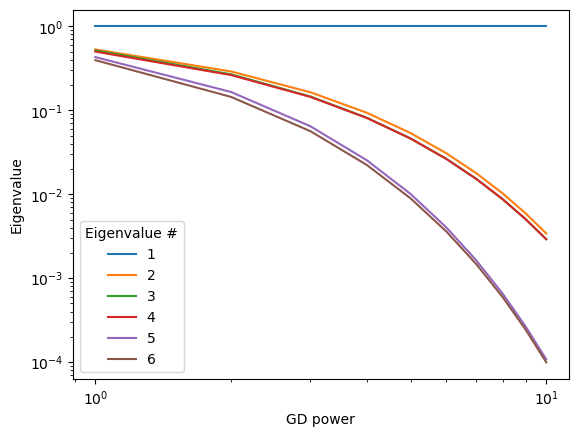

In [23]:
%matplotlib inline

plt.xscale('log')
plt.yscale('log')
plt.xlabel('GD power')
plt.ylabel('Eigenvalue')
for i in range(6):
    plt.plot(gd_power, eigs_1[:,i]/eigs_1[:,0], label= i+1)
plt.legend(title='Eigenvalue #')

In [13]:
def node_investigator(node_id):
    node_info = nodes.iloc[node_id]
    osmid = node_info.osmid
    print(node_info)
    print(edges.loc[osmid])
    

In [14]:
node_investigator(0)

osmid                                  104804
y                                   51.463003
x                                   -2.584859
street_count                                3
highway                                   NaN
ref                                       NaN
geometry        POINT (-2.5848588 51.4630034)
Name: 0, dtype: object
                 osmid             name       highway maxspeed  oneway  \
v         key                                                            
283348151 0    3878220   Grosvenor Road  unclassified   20 mph   False   
21591965  0    8172814  Brighton Street   residential      NaN   False   
282237615 0    3878220   Grosvenor Road  unclassified   20 mph   False   

              reversed  length  \
v         key                    
283348151 0       True  57.641   
21591965  0      False  41.061   
282237615 0      False  12.316   

                                                        geometry lanes  ref  \
v         key                     

In [337]:
nodes.index[nodes.osmid == 983636667]

Index([905], dtype='int64')

In [17]:
center_id = 50000
center = (nodes.iloc[center_id].y, nodes.iloc[center_id].x)

m = folium.Map(location=center, zoom_start=15)
folium.Marker(location=center,icon=folium.Icon(color='red',icon='camera', prefix='fa')).add_to(m)
m

In [18]:
from shapely.geometry import LineString

In [131]:
node_finder(edges.name == 'Tyndall Avenue')

Index([287, 1321, 3021, 3022, 3023, 3558, 3560, 3641, 3647], dtype='int64')

In [136]:
node_finder((nodes.y <= 51.456) & (nodes.y >= 51.455) & (nodes.x <= -2.6) & (nodes.x >= -2.604), type = 'nodes')

Index([  79,  234,  544,  647,  686,  718,  789,  984,  985,  986,  987, 1317,
       1480, 1587, 1590, 1969, 1970, 2044, 2045, 2894, 3409, 3443, 3444, 3445,
       3446, 3447, 3448, 3449, 3450, 3454, 3455, 3456, 3457, 3458, 3459, 3460,
       3472, 3473, 3474, 3475, 3492, 3550],
      dtype='int64')

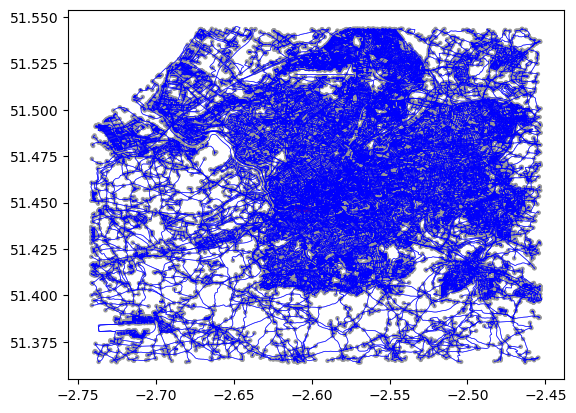

In [19]:

import matplotlib.cm as cm

%matplotlib inline

# colors = (kmeans.labels_ +1 ).astype('int')

colors = np.ones(len(nodes)) *3
sizes = np.ones(len(nodes))*5
alphas = np.ones(len(nodes))

# uni nodes
# colors[node_finder(nodes, edges, (nodes.y <= 51.459) & (nodes.y >= 51.457) & (nodes.x <= -2.6) & (nodes.x >= -2.604), type = 'nodes')] = 1

riverside_nodes = node_finder(nodes, edges, (nodes.y <= 51.447) & (nodes.y >= 51.446) & (nodes.x <= -2.6) & (nodes.x >= -2.61), type = 'nodes')
colors[riverside_nodes] = 1
sizes[riverside_nodes] = 20

# step_nodes = [685, 1880, 65, 415, 478]
# colors[step_nodes]  = 1
# sizes[step_nodes] = 20

# one_d_nodes = [1191, 3785, 3786]
# colors[one_d_nodes]  = 2
# sizes[one_d_nodes] = 20

# two_d_nodes = [0, 200, 400, 600, 800, 1000]
# colors[two_d_nodes]  = 1
# sizes[two_d_nodes] = 20

# # plot nodes.y against nodes.x
# plt.scatter(np.array(nodes.x), np.array(nodes.y), c=colors, s=sizes, cmap=cm.get_cmap('Set1'))
# add the edges to the plot
for i in range(len(edges)):
    geometry = edges.iloc[i].geometry
    if isinstance(geometry, LineString):
        x, y = geometry.xy
        plt.plot(x, y, 'b-', linewidth=0.5, alpha=0.7)  # Plot the geometry in blue
# plot nodes.y against nodes.x
plt.scatter(np.array(nodes.x), np.array(nodes.y), c=colors, s=sizes, cmap=cm.get_cmap('Set1'))

# Show the plot
plt.show()



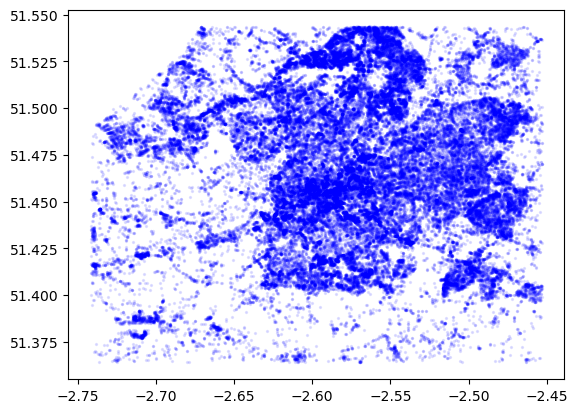

In [14]:
plt.scatter(np.array(nodes.x), np.array(nodes.y), c='blue', s=2, alpha=0.1, cmap=cm.get_cmap('Set1'))

In [24]:
gd_power = np.linspace(1,10,10)
# z_nodes = [0, 551, 172, 365, 2048, 2103]
z_nodes = [0, 200, 400, 600, 800, 1000]

eigs_1 = local_eigenvalues_gd(A, z_nodes[0], gd_power, m=10)
eigs_2 = local_eigenvalues_gd(A, z_nodes[1], gd_power, m=10)
eigs_3 = local_eigenvalues_gd(A, z_nodes[2], gd_power, m=10)
eigs_4 = local_eigenvalues_gd(A, z_nodes[3], gd_power, m=10)
eigs_5 = local_eigenvalues_gd(A, z_nodes[4], gd_power, m=10)
eigs_6 = local_eigenvalues_gd(A, z_nodes[5], gd_power, m=10)


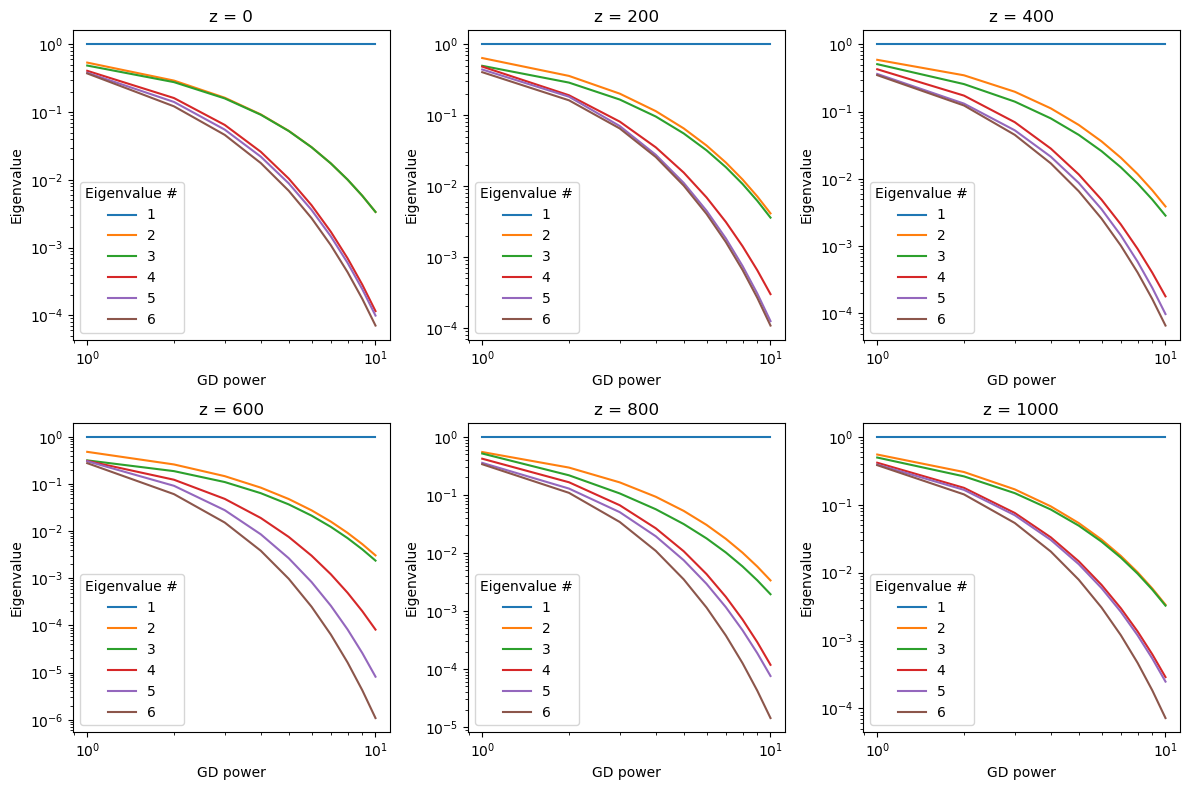

In [25]:
%matplotlib inline

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plot 1: eigs_1
for i in range(6):
    axs[0, 0].plot(gd_power, eigs_1[:, i] / eigs_1[:, 0], label=i + 1)
axs[0, 0].set_title(r'z = {}'.format(z_nodes[0]))
axs[0, 0].set_xlabel('GD power')
axs[0, 0].set_ylabel('Eigenvalue')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].legend(title='Eigenvalue #')

# Plot 2: eigs_2
for i in range(6):
    axs[0, 1].plot(gd_power, eigs_2[:, i] / eigs_2[:, 0], label=i + 1)
axs[0, 1].set_title(r'z = {}'.format(z_nodes[1]))
axs[0, 1].set_xlabel('GD power')
axs[0, 1].set_ylabel('Eigenvalue')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].legend(title='Eigenvalue #')

# Plot 3: eigs_3
for i in range(6):
    axs[0, 2].plot(gd_power, eigs_3[:, i] / eigs_3[:, 0], label=i + 1)
axs[0, 2].set_title(r'z = {}'.format(z_nodes[2]))
axs[0, 2].set_xlabel('GD power')
axs[0, 2].set_ylabel('Eigenvalue')
axs[0, 2].set_xscale('log')
axs[0, 2].set_yscale('log')
axs[0, 2].legend(title='Eigenvalue #')

# Plot 4: eigs_4
for i in range(6):
    axs[1, 0].plot(gd_power, eigs_4[:, i] / eigs_4[:, 0], label=i + 1)
axs[1, 0].set_title(r'z = {}'.format(z_nodes[3]))
axs[1, 0].set_xlabel('GD power')
axs[1, 0].set_ylabel('Eigenvalue')
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].legend(title='Eigenvalue #')

# Plot 5: eigs_5
for i in range(6):
    axs[1, 1].plot(gd_power, eigs_5[:, i] / eigs_5[:, 0], label=i + 1)
axs[1, 1].set_title(r'z = {}'.format(z_nodes[4]))
axs[1, 1].set_xlabel('GD power')
axs[1, 1].set_ylabel('Eigenvalue')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].legend(title='Eigenvalue #')

# Plot 6: eigs_6
for i in range(6):
    axs[1, 2].plot(gd_power, eigs_6[:, i] / eigs_6[:, 0], label=i + 1)
axs[1, 2].set_title(r'z = {}'.format(z_nodes[5]))
axs[1, 2].set_xlabel('GD power')
axs[1, 2].set_ylabel('Eigenvalue')
axs[1, 2].set_xscale('log')
axs[1, 2].set_yscale('log')
axs[1, 2].legend(title='Eigenvalue #')

plt.tight_layout()
plt.show()


In [26]:
# Step nodes
z_nodes = [65, 478, 489, 610, 541, 1880]

eigs_1 = local_eigenvalues_gd(A, z_nodes[0], gd_power, m=10)
eigs_2 = local_eigenvalues_gd(A, z_nodes[1], gd_power, m=10)
eigs_3 = local_eigenvalues_gd(A, z_nodes[2], gd_power, m=10)
eigs_4 = local_eigenvalues_gd(A, z_nodes[3], gd_power, m=10)
eigs_5 = local_eigenvalues_gd(A, z_nodes[4], gd_power, m=10)
eigs_6 = local_eigenvalues_gd(A, z_nodes[5], gd_power, m=10)

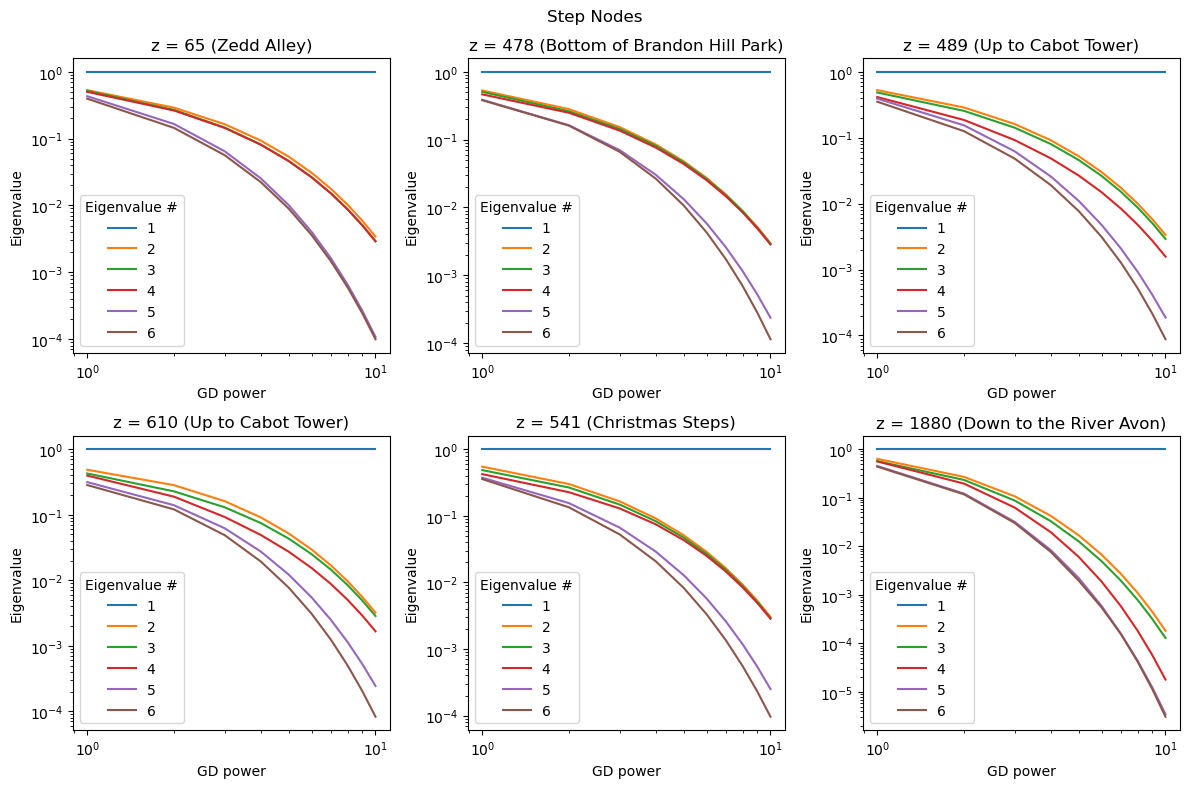

In [27]:
%matplotlib inline

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plot 1: eigs_1
for i in range(6):
    axs[0, 0].plot(gd_power, eigs_1[:, i] / eigs_1[:, 0], label=i + 1)
axs[0, 0].set_title(r'z = {} (Zedd Alley)'.format(z_nodes[0]))
axs[0, 0].set_xlabel('GD power')
axs[0, 0].set_ylabel('Eigenvalue')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].legend(title='Eigenvalue #')

# Plot 2: eigs_2
for i in range(6):
    axs[0, 1].plot(gd_power, eigs_2[:, i] / eigs_2[:, 0], label=i + 1)
axs[0, 1].set_title(r'z = {} (Bottom of Brandon Hill Park)'.format(z_nodes[1]))
axs[0, 1].set_xlabel('GD power')
axs[0, 1].set_ylabel('Eigenvalue')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].legend(title='Eigenvalue #')

# Plot 3: eigs_3
for i in range(6):
    axs[0, 2].plot(gd_power, eigs_3[:, i] / eigs_3[:, 0], label=i + 1)
axs[0, 2].set_title(r'z = {} (Up to Cabot Tower)'.format(z_nodes[2]))
axs[0, 2].set_xlabel('GD power')
axs[0, 2].set_ylabel('Eigenvalue')
axs[0, 2].set_xscale('log')
axs[0, 2].set_yscale('log')
axs[0, 2].legend(title='Eigenvalue #')

# Plot 4: eigs_4
for i in range(6):
    axs[1, 0].plot(gd_power, eigs_4[:, i] / eigs_4[:, 0], label=i + 1)
axs[1, 0].set_title(r'z = {} (Up to Cabot Tower)'.format(z_nodes[3]))
axs[1, 0].set_xlabel('GD power')
axs[1, 0].set_ylabel('Eigenvalue')
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].legend(title='Eigenvalue #')

# Plot 5: eigs_5
for i in range(6):
    axs[1, 1].plot(gd_power, eigs_5[:, i] / eigs_5[:, 0], label=i + 1)
axs[1, 1].set_title(r'z = {} (Christmas Steps)'.format(z_nodes[4]))
axs[1, 1].set_xlabel('GD power')
axs[1, 1].set_ylabel('Eigenvalue')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].legend(title='Eigenvalue #')

# Plot 6: eigs_6
for i in range(6):
    axs[1, 2].plot(gd_power, eigs_6[:, i] / eigs_6[:, 0], label=i + 1)
axs[1, 2].set_title(r'z = {} (Down to the River Avon)'.format(z_nodes[5]))
axs[1, 2].set_xlabel('GD power')
axs[1, 2].set_ylabel('Eigenvalue')
axs[1, 2].set_xscale('log')
axs[1, 2].set_yscale('log')
axs[1, 2].legend(title='Eigenvalue #')

plt.suptitle('Step Nodes')
plt.tight_layout()
plt.show()


In [15]:
# Step nodes
gd_power = np.linspace(1,10,10)
z_nodes = [478, 489, 610]

eigs_1 = local_eigenvalues_gd(A, z_nodes[0], gd_power, m=10)
eigs_2 = local_eigenvalues_gd(A, z_nodes[1], gd_power, m=10)
eigs_3 = local_eigenvalues_gd(A, z_nodes[2], gd_power, m=10)


In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: eigs_1
for i in range(6):
    axs[0].plot(gd_power, eigs_1[:, i], label=i + 1)
axs[0].set_title(r'z = {}'.format(z_nodes[0]))
axs[0].set_xlabel('GD power')
axs[0].set_ylabel('Eigenvalue')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(title='Eigenvalue #', loc='lower left')

# Plot 2: eigs_2
for i in range(6):
    axs[1].plot(gd_power, eigs_2[:, i], label=i + 1)
axs[1].set_title(r'z = {}'.format(z_nodes[1]))
axs[1].set_xlabel('GD power')
axs[1].set_ylabel('Eigenvalue')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend(title='Eigenvalue #', loc='lower left')

# Plot 3: eigs_3
for i in range(6):
    axs[2].plot(gd_power, eigs_3[:, i], label=i + 1)
axs[2].set_title(r'z = {}'.format(z_nodes[2]))
axs[2].set_xlabel('GD power')
axs[2].set_ylabel('Eigenvalue')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].legend(title='Eigenvalue #', loc='lower left')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [436]:
z_nodes = [1191, 3785, 3786, 415]

eigs_1 = local_eigenvalues_gd(A, z_nodes[0], gd_power, m=10)
eigs_2 = local_eigenvalues_gd(A, z_nodes[1], gd_power, m=10)
eigs_3 = local_eigenvalues_gd(A, z_nodes[2], gd_power, m=10)


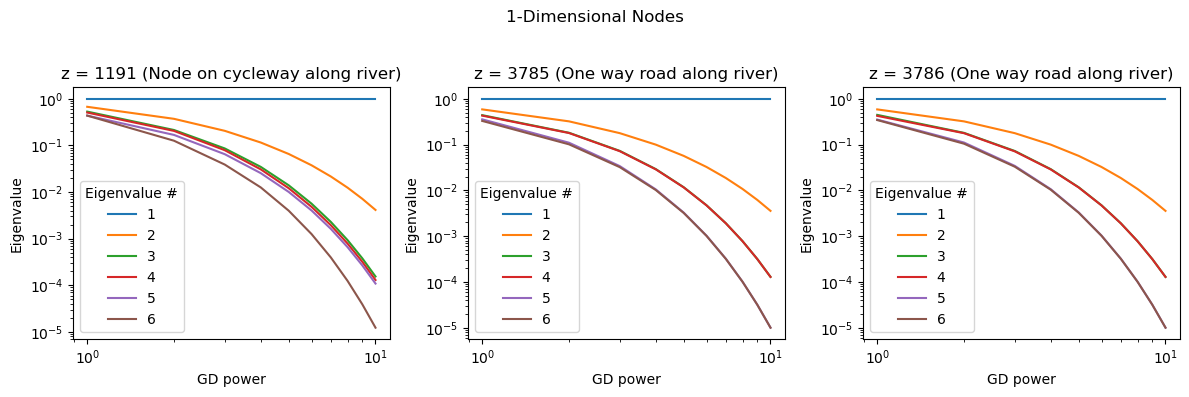

In [444]:
%matplotlib inline

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: eigs_1
for i in range(6):
    axs[0].plot(gd_power, eigs_1[:, i] / eigs_1[:, 0], label=i + 1)
axs[0].set_title(r'z = {} (Node on cycleway along river)'.format(z_nodes[0]))
axs[0].set_xlabel('GD power')
axs[0].set_ylabel('Eigenvalue')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(title='Eigenvalue #', loc='lower left')

# Plot 2: eigs_2
for i in range(6):
    axs[1].plot(gd_power, eigs_2[:, i] / eigs_2[:, 0], label=i + 1)
axs[1].set_title(r'z = {} (One way road along river)'.format(z_nodes[1]))
axs[1].set_xlabel('GD power')
axs[1].set_ylabel('Eigenvalue')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend(title='Eigenvalue #', loc='lower left')

# Plot 3: eigs_3
for i in range(6):
    axs[2].plot(gd_power, eigs_3[:, i] / eigs_3[:, 0], label=i + 1)
axs[2].set_title(r'z = {} (One way road along river)'.format(z_nodes[2]))
axs[2].set_xlabel('GD power')
axs[2].set_ylabel('Eigenvalue')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].legend(title='Eigenvalue #', loc='lower left')

plt.suptitle('1-Dimensional Nodes')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [58]:
w, v = sLA.eigsh(A, 100, which='LA')

In [59]:
w = w[::-1]

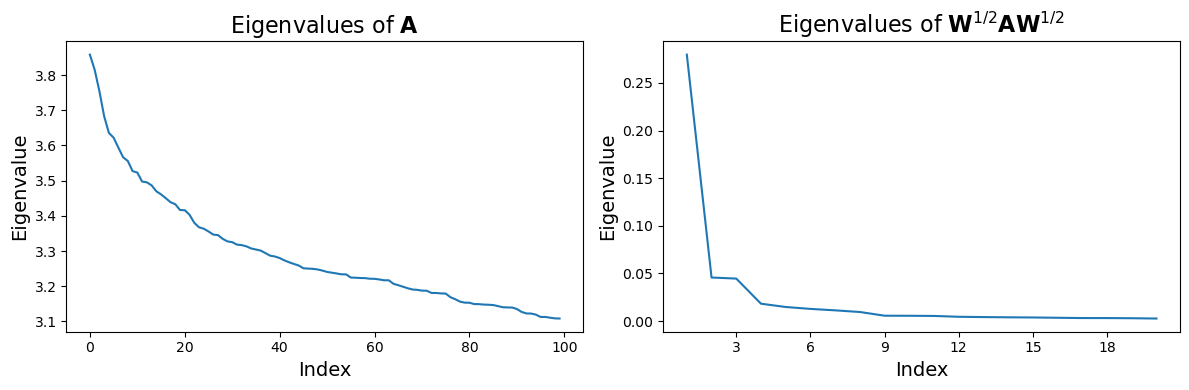

In [72]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the eigenvalues of A
axs[0].plot(w[0:100])
axs[0].set_xlabel('Index', fontsize=14)
axs[0].set_ylabel('Eigenvalue', fontsize=14)
axs[0].set_title(r'Eigenvalues of $\mathbf{A}$', fontsize=16)

# Plot the first row of eigvals with integer indices
axs[1].plot(range(1, 21), eigvals[0, 0:20])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].set_xlabel('Index', fontsize=14)
axs[1].set_ylabel('Eigenvalue', fontsize=14)
axs[1].set_title(r'Eigenvalues of $\mathbf{W}^{1/2} \mathbf{A} \mathbf{W}^{1/2}$', fontsize=16)

plt.tight_layout()
plt.show()


In [55]:
local_strength = [3,4,5]
m =20
z=0

n = A.shape[0]
G = nx.from_numpy_matrix(A)
D = dict(nx.shortest_path_length(G))

eigvals = np.zeros((len(local_strength), m))
weights = np.zeros(n)
weights[np.array(list(D[z].keys()))] = 1 / (np.array(list(D[z].values())) + 1)


for j in range(len(local_strength)):
    W = scipy.sparse.diags( (weights**(local_strength[j]) / sum(weights**(local_strength[j])))**(1/2) )
    w, v = sLA.eigsh(W@A@W, m, which='LA')
    w = w[::-1]
    eigvals[j,:] = w

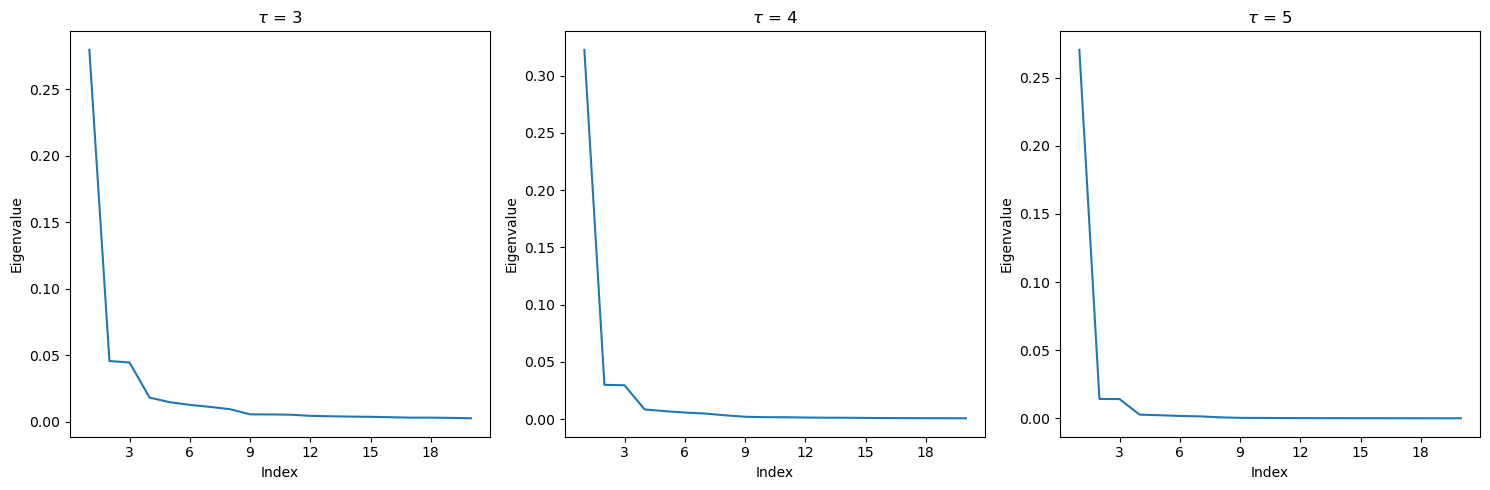

In [56]:
from matplotlib.ticker import MaxNLocator

%matplotlib inline

fig, axs = plt.subplots(1, len(local_strength), figsize=(15, 5))

# Plot each row of eigvals in separate subplots
for i in range(3):
    axs[i].plot(np.arange(m) + 1, eigvals[i, :])
    axs[i].set_title(fr'$\tau$ = {local_strength[i]}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Eigenvalue')
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure whole number ticks
    # axs[i].set_ylim(bottom=0)  # Set the y-axis to start at 0

plt.tight_layout()
plt.show()

In [25]:
z=200
# z=3785 #(1-d node)

weights = gd_weights(A, z)

: 

In [85]:
LSE = local_embedding(A, 3, weights**(0.2))

In [86]:
x = np.array(nodes.x)
y = np.array(nodes.y)

true_coords = np.column_stack((x, y))
true_z_coord = [nodes.iloc[z].x, nodes.iloc[z].y]
distances = np.linalg.norm(true_coords - true_z_coord, axis=1)
closest_nodes = np.argsort(distances)[:1000]

In [82]:
# LSE=LSE_pca
# x = x[filter]
# y=y[filter]

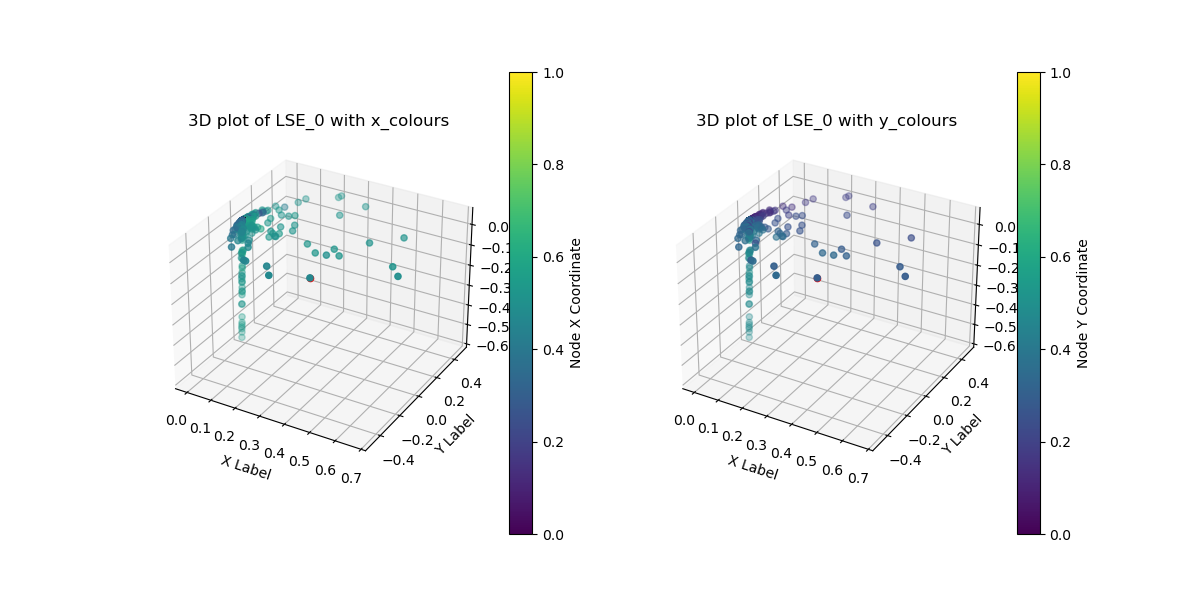

In [87]:
%matplotlib widget

fig = plt.figure(figsize=(12, 6))

# create 3D plot of LSE_0 with x_colours
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(LSE[:, 0], LSE[:, 1], LSE[:, 2], c=x, cmap='viridis', marker='o')
sc1 = ax1.scatter(LSE[z, 0], LSE[z, 1], LSE[z, 2], c='red', marker='o')
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('3D plot of LSE_0 with x_colours')
fig.colorbar(sc1, ax=ax1, label='Node X Coordinate')

# create 3D plot of LSE_0 with y_colours
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(LSE[:, 0], LSE[:, 1], LSE[:, 2], c=y[:], cmap='viridis', marker='o')
sc2 = ax2.scatter(LSE[z, 0], LSE[z, 1], LSE[z, 2], c='red', marker='o')
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('3D plot of LSE_0 with y_colours')
fig.colorbar(sc2, ax=ax2, label='Node Y Coordinate')

plt.show()

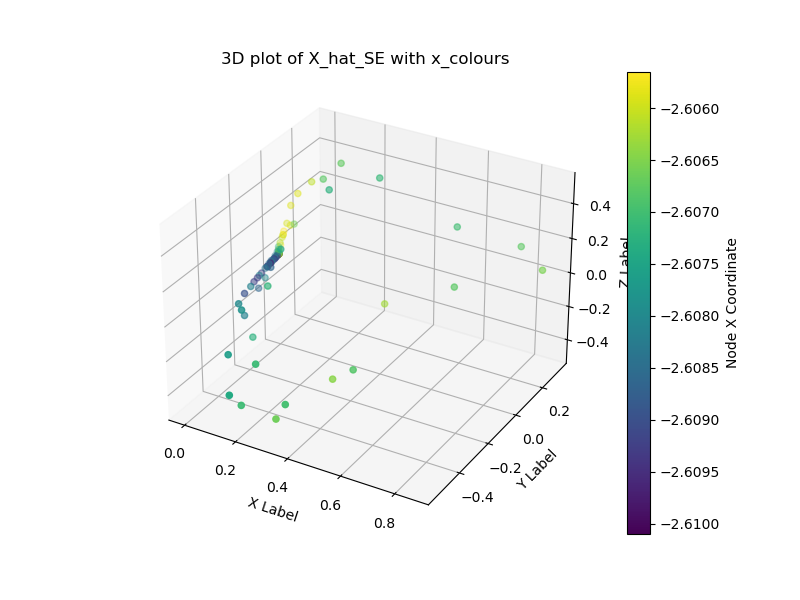

In [78]:
X_hat_SE = SE(A[np.ix_(closest_nodes, closest_nodes)], 3)

%matplotlib widget

fig = plt.figure(figsize=(8, 6))

# create 3D plot of X_hat_SE with x_colours
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_hat_SE[:, 0], X_hat_SE[:, 1], X_hat_SE[:, 2], c=x[closest_nodes], cmap='viridis', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D plot of X_hat_SE with x_colours')
fig.colorbar(sc, ax=ax, label='Node X Coordinate')

plt.show()

In [59]:
# # Filter out rows with norm less than thresh
#
# row_norms = np.linalg.norm(LSE, axis=1)
# thresh = 0.05
# filter = row_norms >= thresh

# # Filter out true closest nodes
#
# filter = closest_nodes

# Filter out the m closest nodes to LSE[z]
m=50
LSE_distances = np.linalg.norm(LSE - LSE[z], axis=1)
LSE_closest_nodes = np.argsort(LSE_distances)[:50]
filter = LSE_closest_nodes

LSE_filtered = LSE[filter]
true_coords_filtered = true_coords[filter]
x_colours_filtered =x[filter]
y_colours_filtered = y[filter]

In [64]:
from sklearn.decomposition import PCA

# Perform PCA to reduce LSE_filtered to 2 dimensions
pca = PCA(n_components=2)
LSE_pca = pca.fit_transform(LSE_filtered)

# true_z_coord = [nodes.iloc[200].x, nodes.iloc[200].y]
# # filter the 50 closest nodes to the node of interest
# distances = np.linalg.norm(true_coords - true_z_coord, axis=1)
# closest_nodes = np.argsort(distances)[:50]


In [319]:
# LSE into 2 dimensions
# LSE = local_embedding(A, 2, weights**(0.2))

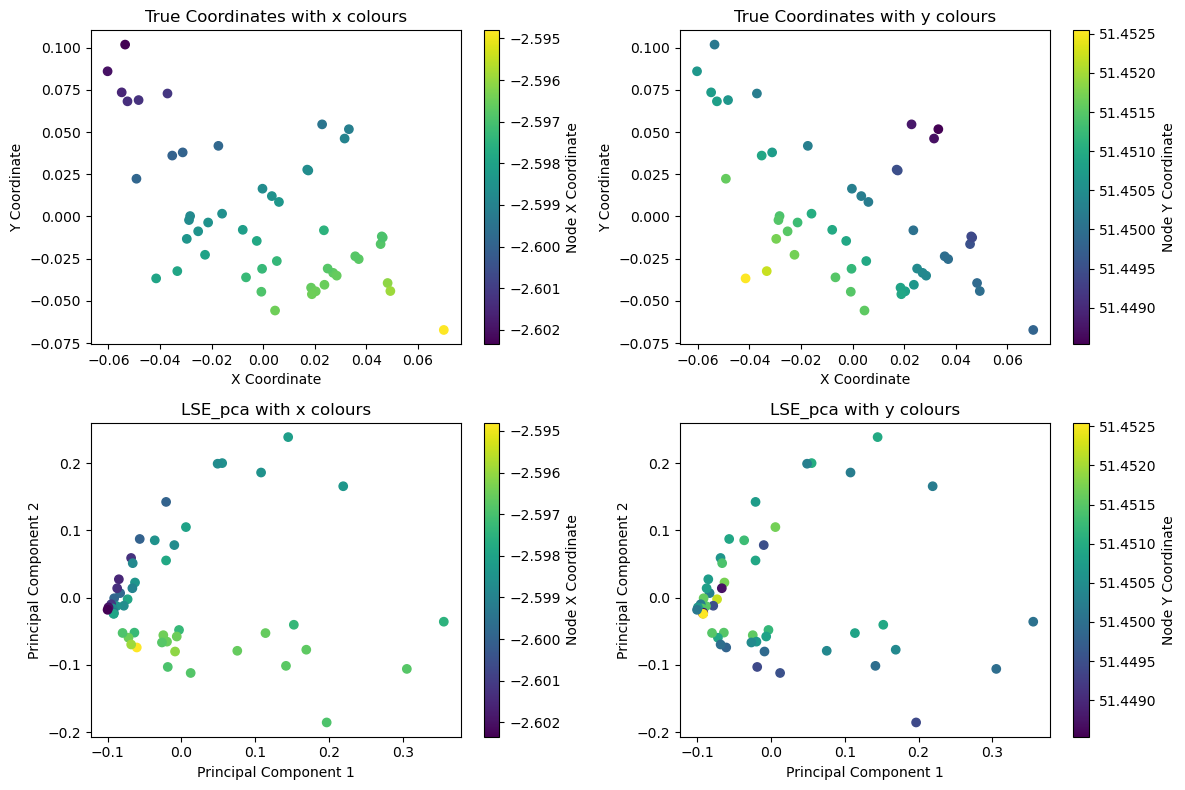

In [66]:
# Procrustes align the true coordinates and the LSE_pca
from scipy.spatial import procrustes

%matplotlib inline
# Perform Procrustes analysis
LSE_pca_procrustes, true_coords_procrustes, disparity = procrustes(LSE_pca, true_coords_filtered)

# Plot the Procrustes aligned true coordinates and LSE_pca for the closest nodes
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(true_coords_procrustes[:, 0], true_coords_procrustes[:, 1], c=x_colours_filtered, cmap='viridis', marker='o')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('True Coordinates with x colours')
plt.colorbar(label='Node X Coordinate')

plt.subplot(2, 2, 3)
plt.scatter(LSE_pca_procrustes[:, 0], LSE_pca_procrustes[:, 1], c=x_colours_filtered, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('LSE_pca with x colours')
plt.colorbar(label='Node X Coordinate')

plt.subplot(2, 2, 2)
plt.scatter(true_coords_procrustes[:, 0], true_coords_procrustes[:, 1], c=y_colours_filtered, cmap='viridis', marker='o')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('True Coordinates with y colours')
plt.colorbar(label='Node Y Coordinate')

plt.subplot(2, 2, 4)
plt.scatter(LSE_pca_procrustes[:, 0], LSE_pca_procrustes[:, 1], c=y_colours_filtered, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('LSE_pca with y colours')
plt.colorbar(label='Node Y Coordinate')

plt.tight_layout()
plt.show()


In [67]:
subgraph_SE_filtered = SE(A[np.ix_(filter, filter)], 2)

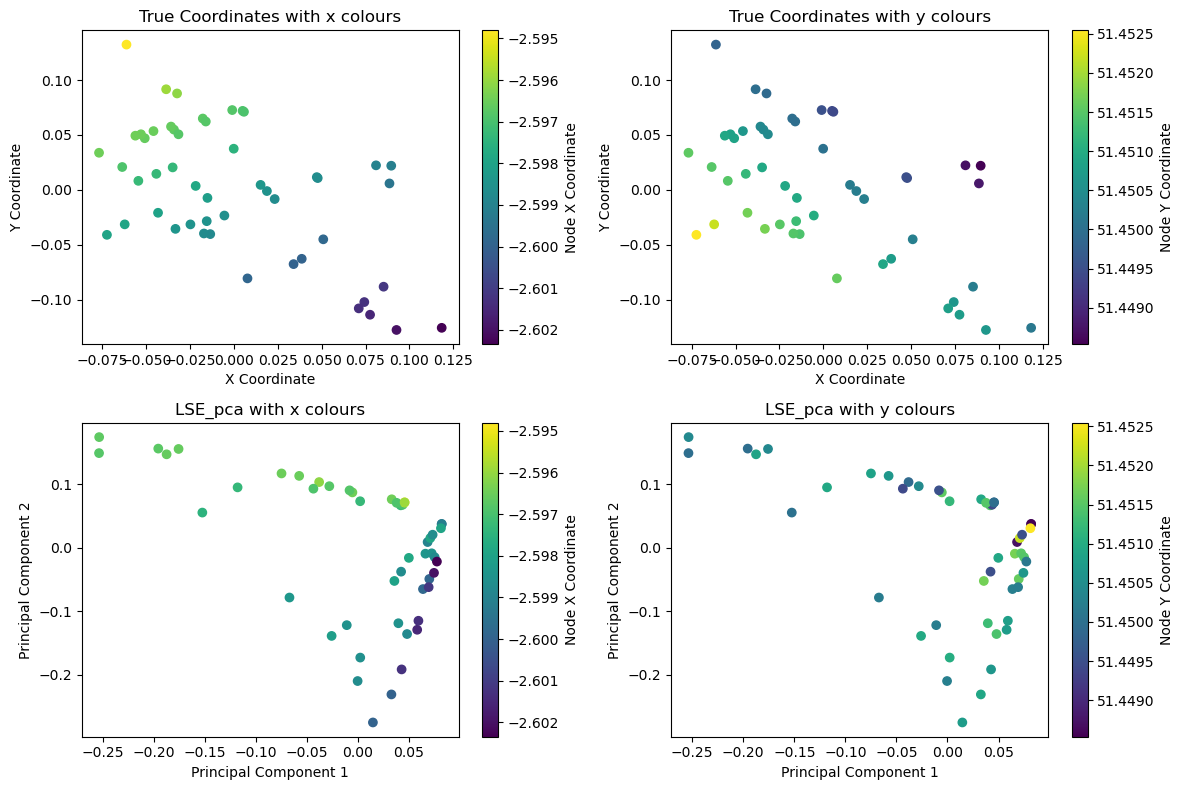

In [68]:
# Perform Procrustes analysis
LSE_pca_procrustes, true_coords_procrustes, disparity = procrustes(subgraph_SE_filtered, true_coords_filtered)

# Plot the Procrustes aligned true coordinates and LSE_pca for the closest nodes
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(true_coords_procrustes[:, 0], true_coords_procrustes[:, 1], c=x_colours_filtered, cmap='viridis', marker='o')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('True Coordinates with x colours')
plt.colorbar(label='Node X Coordinate')

plt.subplot(2, 2, 3)
plt.scatter(LSE_pca_procrustes[:, 0], LSE_pca_procrustes[:, 1], c=x_colours_filtered, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('LSE_pca with x colours')
plt.colorbar(label='Node X Coordinate')

plt.subplot(2, 2, 2)
plt.scatter(true_coords_procrustes[:, 0], true_coords_procrustes[:, 1], c=y_colours_filtered, cmap='viridis', marker='o')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('True Coordinates with y colours')
plt.colorbar(label='Node Y Coordinate')

plt.subplot(2, 2, 4)
plt.scatter(LSE_pca_procrustes[:, 0], LSE_pca_procrustes[:, 1], c=y_colours_filtered, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('LSE_pca with y colours')
plt.colorbar(label='Node Y Coordinate')

plt.tight_layout()
plt.show()